# Hydrogeodesy: Monitoring surface waters from space
### Exercise 4: From river level to discharge

Daniel Scherer, DGFI-TUM  
Wintersemester 2022/23

**Contents**
1. Simple Rating Curve
2. Jones Rating Curve considering hysteresis effect

**Study Area: Mississippi River at Natchez (Mississippi, USA)**  

Discharge Variation:   5000 - 60000 m³/s
Water Level Variation: 5 - 25 m

Following data is used in this exercise:  
- In-Situ discharge and water level data recorded at the Natchez Gauge [USGS]
- Combined satellite altimetry data from Envisat, Jason-2/3, and Sentinel-3A/B [www.dahiti.dgfi.tum.de]

#### Preprocessing
Load the required packages and data:

In [240]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

In [241]:
# these are all pandas series
dahiti_waterlevel = pd.read_pickle('Data/DAHITI_waterlevel.pkl')
insitu_waterlevel = pd.read_pickle('Data/insitu_waterlevel.pkl')
insitu_discharge = pd.read_pickle('Data/insitu_discharge.pkl')

Adjust the water levels time series to a common reference (they are from different sources and reference different vertical datums):

In [242]:
offset = (insitu_waterlevel - dahiti_waterlevel).mean()
dahiti_waterlevel += offset

It is easier to work with the data when we gather all the series in one dataframe:

In [243]:
df = pd.DataFrame({
    'insitu_waterlevel':insitu_waterlevel,
    'insitu_discharge':insitu_discharge,
})
df

,insitu_waterlevel,insitu_discharge
2000-01-01,9.384,NaN
2000-01-02,8.927,NaN
2000-01-03,8.530,6626.0
2000-01-04,8.195,NaN
2000-01-05,7.951,NaN
...,...,...
2019-11-24,16.068,NaN
2019-11-25,15.928,NaN
2019-11-26,15.830,NaN
2019-11-27,15.852,NaN


We can simply find synchron measurements:

In [244]:
df.dropna()

,insitu_waterlevel,insitu_discharge
2000-01-03,8.530,6626.0
2000-01-17,11.517,11808.0
2000-01-31,8.500,7023.0
2000-02-17,7.555,5748.0
2000-02-28,14.383,18717.0
...,...,...
2019-07-15,22.560,42475.0
2019-07-30,20.918,31998.0
2019-08-14,17.949,22313.0
2019-08-27,15.431,15971.0


... and plot the data:

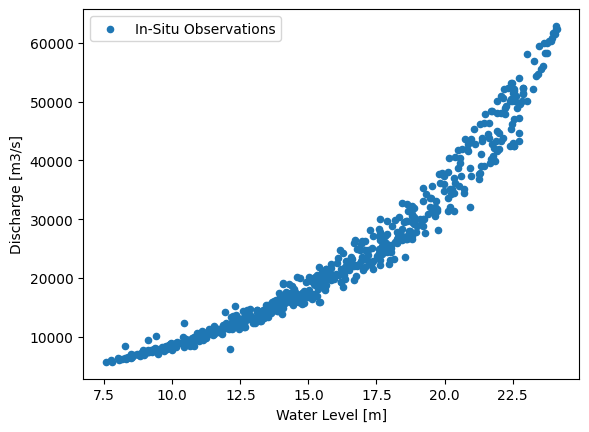

In [245]:
df.plot.scatter('insitu_waterlevel','insitu_discharge',label='In-Situ Observations')
plt.xlabel("Water Level [m]")
plt.ylabel("Discharge [m3/s]")
plt.legend()
plt.show()

**What physical processes might occur at the gauging station judging from the plot above?**  
(see lecture script (20.12.2022, p.20f))

#### 1. Simple Rating Curve

A rating curve models the ratio between water level and discharge.  
It can be used to extend discharge time series over a period where only water level data are available.

In this first step, we fit a simple polznomal function to the data.

Fit a function to the data (Which degree would be suitable?): 

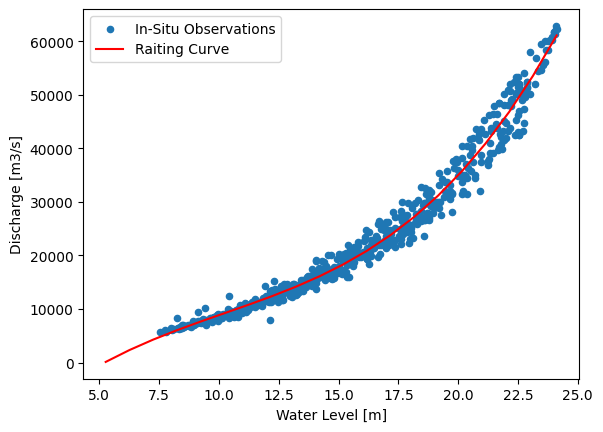

In [246]:
degree = 3 # choose a degree
# np.polyfit fits a polynom to the data using least-squares and returns the coefficients
coefficients = np.polyfit(
    x = df.dropna().insitu_waterlevel,
    y = df.dropna().insitu_discharge,
    deg = degree)
# np.poly1d takes the coefficients and returns the fitted function
fitted_function = np.poly1d(coefficients)

ax = df.plot.scatter('insitu_waterlevel','insitu_discharge',label='In-Situ Observations')
# We create some x values between the min and max waterlevel...
x = np.linspace(df.insitu_waterlevel.min(),df.insitu_waterlevel.max(),20)
# ...and plot them with the y data from the fitted function:
ax.plot(x,fitted_function(x),color='red',label='Raiting Curve')

plt.xlabel("Water Level [m]")
plt.ylabel("Discharge [m3/s]")
plt.legend()
plt.show()

Now calculate a discharge time series and its residuals using the fitted function:

In [247]:
# We apply the fitted function to each waterlevel observation in our pandas series.
# In this way, we get a new discharge series returned with the same indices as the waterlevel series.
rated_insitu = insitu_waterlevel.apply(lambda x: fitted_function(x))
rated_dahiti = dahiti_waterlevel.apply(lambda x: fitted_function(x))

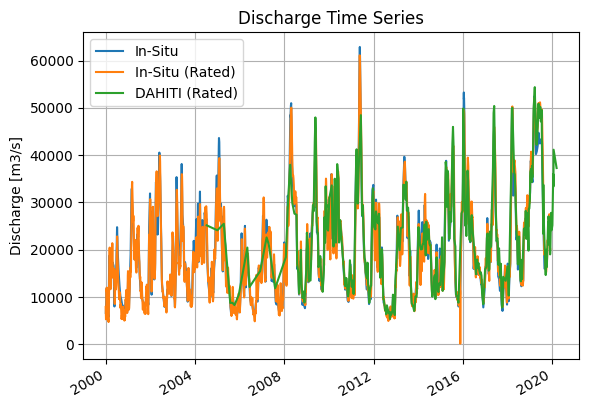

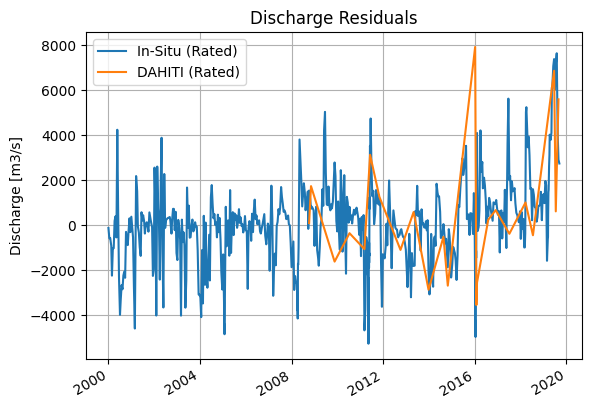

In [248]:
ax = insitu_discharge.plot(label="In-Situ")
rated_insitu.plot(ax=ax, label="In-Situ (Rated)")
rated_dahiti.plot(ax=ax, label="DAHITI (Rated)")
plt.ylabel("Discharge [m3/s]")
plt.title("Discharge Time Series")
plt.grid()
plt.legend()
plt.show()

residuals_dahiti = rated_dahiti - insitu_discharge
residuals_insitu = rated_insitu - insitu_discharge

# Bar plots for time series are a bit messy in Pandas, so we use a line plot for simplicity:
ax = residuals_insitu.dropna().plot(label="In-Situ (Rated)")
residuals_dahiti.dropna().plot(ax=ax, label="DAHITI (Rated)")
plt.title("Discharge Residuals")
plt.ylabel("Discharge [m3/s]")
plt.grid()
plt.legend()
plt.show()

- **When do the largest errors occur?**
- **What could be a possible explanation?**

Additioanlly, calculate the RMSE and NRMSE (normed by the 95th and 5th percentile) for the rated data:

$$ RMSE = \sqrt{\frac{\sum{residuals}^2}{n}}$$

In [249]:
# You can use the numpy sqrt, series.pow(2), and series.mean() functions
rmse_dahiti = np.sqrt(residuals_dahiti.pow(2).mean())
rmse_insitu = np.sqrt(residuals_insitu.pow(2).mean())
norm = insitu_discharge.quantile(0.95) - insitu_discharge.quantile(0.05)

print('Simple Rating Quality Assessment:')
print(f'In-Situ (Rated): RMSE {rmse_insitu:.0f} m3/s; NRMSE {rmse_insitu/norm*100:.0f}% ({residuals_insitu.dropna().shape[0]} of {rated_insitu.dropna().shape[0]}  Samples)')
print(f'DAHITI (Rated): RMSE {rmse_dahiti:.0f} m3/s; NRMSE {rmse_dahiti/norm*100:.0f}% ({residuals_dahiti.dropna().shape[0]} of {rated_dahiti.dropna().shape[0]}  Samples)')

Simple Rating Quality Assessment:
In-Situ (Rated): RMSE 1965 m3/s; NRMSE 4% (580 of 7170  Samples)
DAHITI (Rated): RMSE 2938 m3/s; NRMSE 7% (23 of 355  Samples)


#### 2. Jones Rating

As you saw above the simple rating curve only fits roughly to the actual water level to discharge ratio.

The Jones raiting cosiders additionally the rate of water level change.

In [229]:
delta_t = insitu_waterlevel.index.to_series().diff().dt.days
delta_h = insitu_waterlevel.diff()
insitu_rate_of_change = delta_h / delta_t

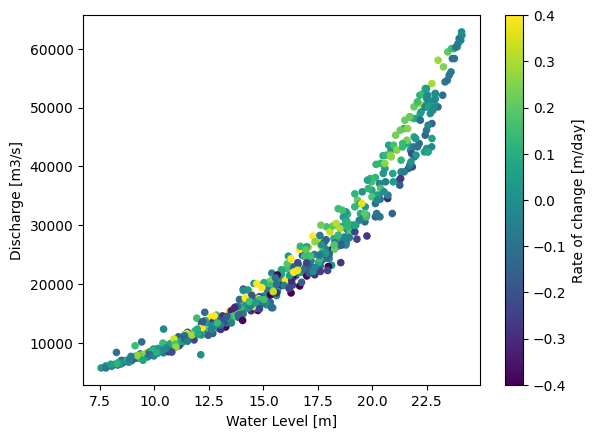

In [230]:
df.loc[:,'rate_of_change'] = insitu_rate_of_change
ax = df.plot.scatter('insitu_waterlevel','insitu_discharge',c="rate_of_change",vmin=-0.4,vmax=0.4)
ax.set_xlabel("Water Level [m]")
ax.set_ylabel("Discharge [m3/s]")
plt.gcf().get_axes()[1].set_ylabel("Rate of change [m/day]")
plt.show()

**What effect can you observe?**

Now we implement the Jones Raiting Curve Function:

$$
Q=Q_n \sqrt{1+\frac{1}{S C} \frac{\Delta h}{\Delta t}}
$$

where
- $Q_n$ is the previously computed discharge using the polynomal function(fitted_function)
- $SC$ is the coefficient to be fitted
- $\frac{\Delta h}{\Delta t}$ is the previously calculated rate of change

In [231]:
# The optimize.curve_fit function expects the input parameters (h and dht) to be stacked in one numpy array
# So first we unpack parameters from the stack
def jones_function(x,sc):
    h, dht = x[:,0], x[:,1]
    Qn = fitted_function(h)
    return Qn * np.sqrt(1+1/sc*dht)

# The optimize.curve_fit returns the fitted coefficient (popt) and its covariance (pcov).
# We only need popt in this case.
popt, pcov = optimize.curve_fit(
    f = jones_function,
    # To fit the function we need synchron waterlevel and discharge observations, so we drop any date missing any data.
    # As mentioned above, we need to stack the input parameters in one numpy array:
    xdata= df.dropna().loc[:,['insitu_waterlevel','rate_of_change']].to_numpy(),
    # The training data:
    ydata = df.dropna().insitu_discharge,
    # We use a Levenberg-Marquardt algorithm to minimze the residuals.
    method="lm"
    )

In [232]:
insitu_jones_discharge = pd.Series(jones_function(df.loc[:,['insitu_waterlevel','rate_of_change']].dropna().to_numpy(),popt),index=df.loc[:,['insitu_waterlevel','rate_of_change']].dropna().index)

/var/folders/rn/lmt69fr111g172j4wx2j53vc0000gn/T/ipykernel_22523/4173411421.py:6: RuntimeWarning: invalid value encountered in sqrt
  return Qn * np.sqrt(1+1/sc*dht)


Now we plot the data from the Jones function.  
You should see many loops covering the training data

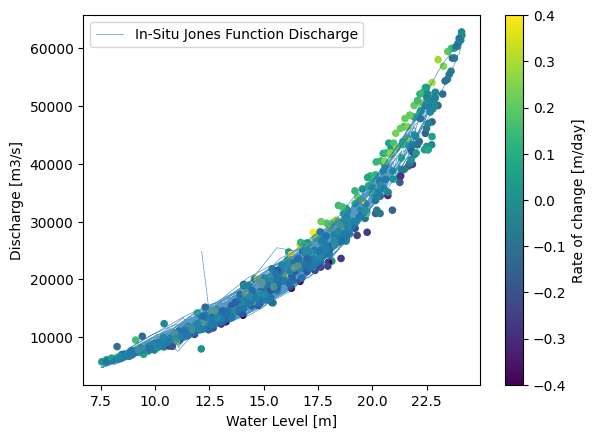

In [233]:
df.loc[:,'rate_of_change'] = insitu_rate_of_change
ax = df.plot.scatter('insitu_waterlevel','insitu_discharge',c="rate_of_change",vmin=-0.4,vmax=0.4)
ax.set_xlabel("Water Level [m]")
ax.set_ylabel("Discharge [m3/s]")
plt.gcf().get_axes()[1].set_ylabel("Rate of change [m/day]")
ax.plot(insitu_waterlevel.loc[insitu_jones_discharge.index],insitu_jones_discharge,alpha=.75,linewidth=.5,label="In-Situ Jones Function Discharge")
plt.legend()
plt.show()

So far, we only used in-situ data with the Jones function.
Now, estimate the discharge using DAHITI data and the fitted Jones function:

In [234]:
delta_t = dahiti_waterlevel.index.to_series().diff().dt.days
delta_h = dahiti_waterlevel.diff()
dahiti_rate_of_change = delta_h / delta_t

dahiti_jones_discharge = pd.Series(jones_function(np.array([dahiti_waterlevel,dahiti_rate_of_change]).T,popt),index=dahiti_waterlevel.index)

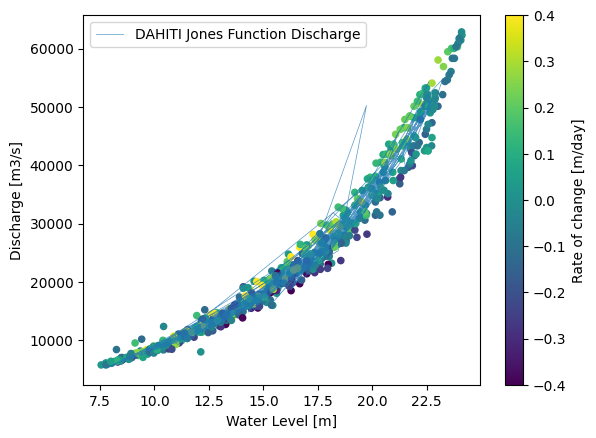

In [235]:
df.loc[:,'rate_of_change'] = insitu_rate_of_change
ax = df.plot.scatter('insitu_waterlevel','insitu_discharge',c="rate_of_change",vmin=-0.4,vmax=0.4)
ax.set_xlabel("Water Level [m]")
ax.set_ylabel("Discharge [m3/s]")
plt.gcf().get_axes()[1].set_ylabel("Rate of change [m/day]")
ax.plot(dahiti_waterlevel,dahiti_jones_discharge,alpha=.75,linewidth=.5,label="DAHITI Jones Function Discharge")
plt.legend()
plt.show()

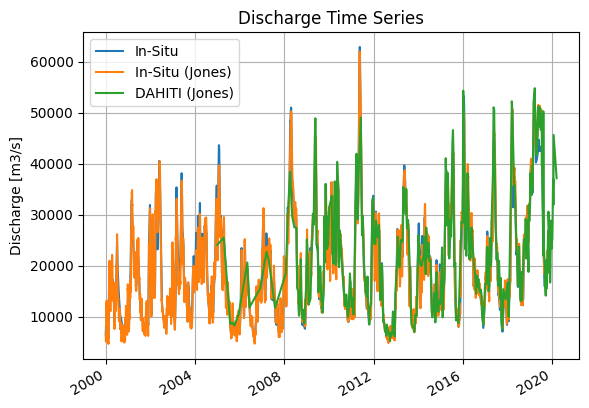

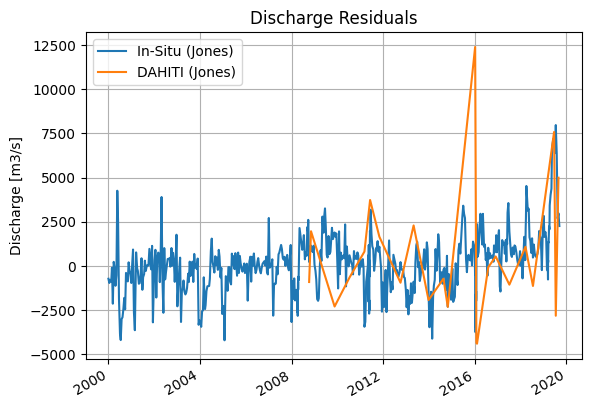

In [236]:
ax = insitu_discharge.plot(label="In-Situ")
insitu_jones_discharge.plot(ax=ax, label="In-Situ (Jones)")
dahiti_jones_discharge.plot(ax=ax, label="DAHITI (Jones)")
plt.ylabel("Discharge [m3/s]")
plt.title("Discharge Time Series")
plt.grid()
plt.legend()
plt.show()

residuals_dahiti = dahiti_jones_discharge - insitu_discharge
residuals_insitu = insitu_jones_discharge - insitu_discharge

# Bar plots for time series are a bit messy in Pandas, so we use a line plot for simplicity:
ax = residuals_insitu.dropna().plot(label="In-Situ (Jones)")
residuals_dahiti.dropna().plot(ax=ax, label="DAHITI (Jones)")
plt.title("Discharge Residuals")
plt.ylabel("Discharge [m3/s]")
plt.grid()
plt.legend()
plt.show()

In [237]:
rmse_dahiti = np.sqrt(residuals_dahiti.pow(2).mean())
rmse_insitu = np.sqrt(residuals_insitu.pow(2).mean())
norm = insitu_discharge.quantile(0.95) - insitu_discharge.quantile(0.05)

print('Jones Rating Quality Assessment:')
print(f'In-Situ (Jones): RMSE {rmse_insitu:.0f} m3/s; NRMSE {rmse_insitu/norm*100:.0f}% ({residuals_insitu.dropna().shape[0]} of {insitu_jones_discharge.dropna().shape[0]} Samples validated)')
print(f'DAHITI (Jones): RMSE {rmse_dahiti:.0f} m3/s; NRMSE {rmse_dahiti/norm*100:.0f}% ({residuals_dahiti.dropna().shape[0]} of {dahiti_jones_discharge.dropna().shape[0]} Samples validated)')

Jones Rating Quality Assessment:
In-Situ (Jones): RMSE 1675 m3/s; NRMSE 4% (580 of 7168 Samples validated)
DAHITI (Jones): RMSE 3785 m3/s; NRMSE 8% (23 of 354 Samples validated)


Compare the Jones rated DAHITI discharge to the insitu discharge:

In [238]:
residuals_simple = rated_dahiti - insitu_jones_discharge
rmse_simple = np.sqrt(residuals_simple.pow(2).mean())

residuals_jones = dahiti_jones_discharge - insitu_jones_discharge
rmse_jones = np.sqrt(residuals_jones.pow(2).mean())

print(f'DAHITI (Simple) vs In-Situ (Jones): RMSE {rmse_simple:.0f} m3/s; NRMSE {rmse_simple/norm*100:.0f}% ({residuals_simple.dropna().shape[0]} of {rated_dahiti.dropna().shape[0]} Samples validated)')
print(f'DAHITI (Jones) vs In-Situ (Jones): RMSE {rmse_jones:.0f} m3/s; NRMSE {rmse_jones/norm*100:.0f}% ({residuals_jones.dropna().shape[0]} of {dahiti_jones_discharge.dropna().shape[0]} Samples validated)')

DAHITI (Simple) vs In-Situ (Jones): RMSE 2382 m3/s; NRMSE 5% (339 of 355 Samples validated)
DAHITI (Jones) vs In-Situ (Jones): RMSE 3043 m3/s; NRMSE 7% (338 of 354 Samples validated)


- **How is the quality of the derived data?**
- **Are there large deviations and how could they be explained?**

In [ ]:
# This deletes all dahiti_waterlevel with an error greater 10 cm:
dahiti_waterlevel = dahiti_waterlevel[(dahiti_waterlevel - insitu_waterlevel).abs() < 0.1]